# Import Modules
This section imports the required modules and prepare the raw content of the file in the desired
data type for performance

In [214]:
import re
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px

#!pip install --quiet pycountry_convert
from pycountry_convert import country_alpha2_to_country_name, country_name_to_country_alpha3
from zipfile import ZipFile
from wordcloud import WordCloud
from pandas.api.types import CategoricalDtype
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

In [215]:
#!pip install nbformat

In [216]:
def get_alpha3(col):
    try:
        iso_3 =  country_name_to_country_alpha3(col)
    except:
        iso_3 = 'Unknown'
    return iso_3

def get_name(col):
    try:
        name =  country_alpha2_to_country_name(col)
    except:
        name = 'Unknown'
    return name

### Read file

In [217]:
# Read csv file ziped
zip_path = './data/human-trafficking-victims-dataset-ctdc.zip'
data_file = None
raw_data = None
with ZipFile(zip_path) as zip_file:
    for commpresed in zip_file.filelist:
        if commpresed.filename.endswith('csv'):
            with zip_file.open(commpresed) as data_file:
                raw_data = pd.read_csv(
                    data_file,
                    sep=';',
                    header=0,
                    low_memory=False,
                    usecols=range(1,64),)

### Data type conversion

In [218]:
# Setting values of categorical attribute
# for performnce at processing time
# Age numerical categories
age_range = [
    '0--8',
    '9--17',
    '18--20',
    '21--23',
    '24--26',
    '27--29',
    '30--38',
    '39--47',
    '48+'
]
# Gender categories
gender_values = [
    'Male',
    'Female',
    'Transgender/NonConforming',
]
# Age status categories
age_cate = [
    'Adult',
    'Minor',
]
# Data recorders categories
data_source = [
    'Case Management',
    'Hotline'
]
# Categorical pandas objects
age_cat_range = CategoricalDtype(categories=age_range, ordered=True)
gender_cat = CategoricalDtype(categories=gender_values, ordered=False)
age_cat = CategoricalDtype(categories=age_cate, ordered=True)
data_cat_source = CategoricalDtype(categories=data_source, ordered=False)

In [219]:
# Convert all values read as float due to NaN
raw_data = raw_data.apply(lambda serie: serie.astype('Int32', errors='ignore'))
# Converto to categorical types
raw_data['Datasource'] = raw_data['Datasource'].astype(data_cat_source)
raw_data['gender'] = raw_data['gender'].astype(gender_cat)
raw_data['ageBroad'] = raw_data['ageBroad'].astype(age_cat_range)
raw_data['citizenship'] = raw_data['citizenship'].astype("category")
raw_data['yearOfRegistration'] = raw_data['yearOfRegistration'].astype("category")
raw_data['CountryOfExploitation'] = raw_data['CountryOfExploitation'].astype("category")

columns_age_cat = ['majorityStatus', 'majorityStatusAtExploit', 'majorityEntry']
raw_data[columns_age_cat] = raw_data[columns_age_cat].astype(age_cat)

### Dimensionality reduction

In [220]:
# Tomamos las variables cualitativas del dataset junto con las variables que nos sirven como indexación

dataset_columns = [ 'yearOfRegistration', 'Datasource', 'gender', 'ageBroad',
       'majorityStatus', 'majorityStatusAtExploit', 'majorityEntry',
       'citizenship', 'meansOfControlConcatenated','typeOfExploitConcatenated', 'typeOfLabourConcatenated',
       'typeOfSexConcatenated', 'isAbduction', 'RecruiterRelationship',
       'CountryOfExploitation', 'recruiterRelationIntimatePartner',
       'recruiterRelationFriend', 'recruiterRelationFamily',
       'recruiterRelationOther', 'recruiterRelationUnknown'] 

# Generamos un nuevo dataset con esta reducción de dimensionalidad

new_data_set = raw_data.loc[:,dataset_columns]

In [221]:
columns_to_check = ['meansOfControlConcatenated','typeOfExploitConcatenated', 'typeOfLabourConcatenated',
       'typeOfSexConcatenated'] 


new_data_set[columns_to_check] = new_data_set[columns_to_check].replace(0, np.nan)
# Filtrar los registros con datos faltantes solo en las columnas mencionadas
filtered_data = new_data_set[new_data_set[columns_to_check].isnull().all(axis=1)]

In [222]:
filtered_data.shape[0] / new_data_set.shape[0] * 100

25.09667519181586

In [223]:
# Calcular cuántos registros eliminar (90%)
num_records_to_delete = int(len(filtered_data) * 0.9)

# Eliminar el 90% de los registros sin datos
filtered_data = filtered_data.sample(n=num_records_to_delete, random_state=42)

# Restaurar los registros eliminados a new_data_set
new_data_set = new_data_set[~new_data_set.index.isin(filtered_data.index)]

# Imputación de datos faltantes utilizando la moda (valor más común)
imputer = SimpleImputer(strategy='most_frequent')

# Aplicar la imputación solo a las columnas de interés
new_data_set[columns_to_check] = imputer.fit_transform(new_data_set[columns_to_check])

# Verificar el resultado
print(new_data_set.isnull().sum())

# Realizar muestras visuales para verificar la imputación
sample_data = new_data_set.sample(10)  # Muestra aleatoria de 10 registros
print(sample_data[columns_to_check])

yearOfRegistration                    232
Datasource                              0
gender                               6879
ageBroad                            45330
majorityStatus                      25051
majorityStatusAtExploit             54414
majorityEntry                       71580
citizenship                         43080
meansOfControlConcatenated              0
typeOfExploitConcatenated               0
typeOfLabourConcatenated                0
typeOfSexConcatenated                   0
isAbduction                         50251
RecruiterRelationship               16758
CountryOfExploitation               11455
recruiterRelationIntimatePartner    39786
recruiterRelationFriend             39786
recruiterRelationFamily             39786
recruiterRelationOther              39786
recruiterRelationUnknown              236
dtype: int64
      meansOfControlConcatenated typeOfExploitConcatenated  \
65136              Not specified       Sexual exploitation   
27455              Not 

In [224]:
# Lista de campos que necesitan one-hot encoding
fields_to_encode = ['meansOfControlConcatenated', 'typeOfExploitConcatenated', 'typeOfLabourConcatenated', 'typeOfSexConcatenated']

# Itera sobre cada campo y aplica one-hot encoding
for field in fields_to_encode:
    # Divide el campo en múltiples columnas one-hot
    one_hot_encoded = new_data_set[field].str.get_dummies(sep=';')
    
    # Renombra las columnas para que sean únicas
    one_hot_encoded.columns = [f"{field}_{column}" for column in one_hot_encoded.columns]
    
    # Concatena las columnas one-hot al nuevo dataset
    new_data_set = pd.concat([new_data_set, one_hot_encoded], axis=1)
    
# Elimina las columnas originales que ya han sido one-hot encoded
new_data_set = new_data_set.drop(fields_to_encode, axis=1)



In [225]:
new_data_set.shape

(75672, 59)

### Others objects

In [226]:
# Object to perform the word cloud plot
word_cloud = WordCloud(
    contour_color='black',
    collocations=False,
    mode='RGB',
    background_color='white',
    colormap='RdYlBu')

# Categorical objects attributes
categorical_columns = [
    'ageBroad',
    'Datasource',
    'gender',
    'majorityStatus',
    'majorityStatusAtExploit',
    'majorityEntry']

# Categorical countries
country_columns = [
    'citizenship',
    'CountryOfExploitation']

# Method to convert country ISO2 to ISO numeric code
def country_code(country):
    try:
        return pycountry.countries.lookup(country).numeric
    except LookupError:
        # It is a missing data and cannot be convert 'NaN'
        # value of contry to numeric code
        return -1 

# Descriptive analysis



### Data presentation

In [227]:
new_data_set

,yearOfRegistration,Datasource,gender,ageBroad,majorityStatus,majorityStatusAtExploit,majorityEntry,citizenship,isAbduction,RecruiterRelationship,...,typeOfLabourConcatenated_Illicit activities,typeOfLabourConcatenated_Manufacturing,typeOfLabourConcatenated_Not specified,typeOfLabourConcatenated_Other,typeOfLabourConcatenated_Peddling,typeOfLabourConcatenated_Transportation,typeOfSexConcatenated_Pornography,typeOfSexConcatenated_Private sexual services,typeOfSexConcatenated_Prostitution,typeOfSexConcatenated_Remote interactive services
0,2002,Case Management,Female,18--20,Adult,NaN,NaN,CO,0,NaN,...,0,0,0,0,0,0,0,0,1,0
1,2002,Case Management,Female,18--20,Adult,NaN,NaN,CO,0,NaN,...,0,0,0,0,0,0,0,0,1,0
2,2002,Case Management,Female,18--20,Adult,NaN,NaN,CO,0,NaN,...,0,0,0,0,0,0,0,0,1,0
3,2002,Case Management,Female,18--20,Adult,NaN,NaN,CO,0,NaN,...,0,0,0,0,0,0,0,0,1,0
4,2002,Case Management,Female,18--20,Adult,NaN,NaN,CO,0,NaN,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97730,NaN,Case Management,Male,39--47,Adult,NaN,NaN,CM,<NA>,NaN,...,0,0,0,0,0,0,0,0,1,0
97731,NaN,Case Management,Male,39--47,Adult,NaN,NaN,CM,<NA>,NaN,...,0,0,0,0,0,0,0,0,1,0
97732,NaN,Case Management,Male,39--47,Adult,NaN,NaN,CM,<NA>,NaN,...,0,0,0,0,0,0,0,0,1,0
97746,NaN,Case Management,Male,9--17,Minor,NaN,NaN,CM,<NA>,NaN,...,0,0,0,0,0,0,0,0,1,0


In [228]:
new_data_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75672 entries, 0 to 97748
Data columns (total 59 columns):
 #   Column                                                             Non-Null Count  Dtype   
---  ------                                                             --------------  -----   
 0   yearOfRegistration                                                 75440 non-null  category
 1   Datasource                                                         75672 non-null  category
 2   gender                                                             68793 non-null  category
 3   ageBroad                                                           30342 non-null  category
 4   majorityStatus                                                     50621 non-null  category
 5   majorityStatusAtExploit                                            21258 non-null  category
 6   majorityEntry                                                      4092 non-null   category
 7   citizenship       

In [229]:
print(f'The data-set has a total of records and atributes {new_data_set.shape}\n')
print('Count total of data types in data-set')
unique_types = new_data_set.dtypes.value_counts()
print(unique_types.to_string())

The data-set has a total of records and atributes (75672, 59)

Count total of data types in data-set
int64       43
Int32        6
category     3
category     1
category     1
category     1
category     1
category     1
object       1
category     1


In [230]:
# NaN values per record in data-set
nan_record = new_data_set.isna().sum(axis=1).describe()
print('Misising "NaN" attributes per record')
print(nan_record.to_string(header=True))

Misising "NaN" attributes per record
count    75672.000000
mean         6.401443
std          2.852019
min          0.000000
25%          4.000000
50%          7.000000
75%          9.000000
max         12.000000


In [231]:
# NaN values per attribute in data-set
nan_attribute = raw_data.isna().sum()
ratio_nan = nan_attribute / raw_data.shape[0]
print('Ratio of missing values in attributes', ratio_nan.to_string(), sep='\n')

Ratio of missing values in attributes
yearOfRegistration                        0.020573
Datasource                                0.000000
gender                                    0.083253
ageBroad                                  0.478598
majorityStatus                            0.271141
majorityStatusAtExploit                   0.782240
majorityEntry                             0.925811
citizenship                               0.454834
meansOfControlDebtBondage                 0.915754
meansOfControlTakesEarnings               0.882987
meansOfControlRestrictsFinancialAccess    0.955693
meansOfControlThreats                     0.841156
meansOfControlPsychologicalAbuse          0.849248
meansOfControlPhysicalAbuse               0.877923
meansOfControlSexualAbuse                 0.907795
meansOfControlFalsePromises               0.916890
meansOfControlPsychoactiveSubstances      0.887754
meansOfControlRestrictsMovement           0.855621
meansOfControlRestrictsMedicalCare        0.

In [232]:
duplicates = new_data_set.duplicated().sum()
ration_dup = duplicates / new_data_set.shape[0]
print(f'Total of elements duplicateds: {duplicates}\nRatio of all data-set: {ration_dup:.2%}')

Total of elements duplicateds: 57424
Ratio of all data-set: 75.89%


In [233]:
new_data_set["country"] = new_data_set["citizenship"].apply(lambda x: get_name(x))
new_data_set["alpha_3"] = new_data_set["country"].apply(lambda x: get_alpha3(x))
data_map = pd.DataFrame(new_data_set.groupby(["country","alpha_3"])["alpha_3"].agg(Victims="count")).reset_index()
country_victims = data_map.groupby(["alpha_3"])["Victims"].sum().reset_index()
fig = px.choropleth(country_victims, locations = "alpha_3",
                    color = "Victims",
                    color_continuous_scale="Viridis_r")

fig.show()

In [250]:
new_data_set["country"] = new_data_set["CountryOfExploitation"].apply(lambda x: get_name(x))
new_data_set["alpha_3"] = new_data_set["country"].apply(lambda x: get_alpha3(x))
data_map = pd.DataFrame(new_data_set.groupby(["country","alpha_3"])["alpha_3"].agg(Victims="count")).reset_index()
country_victims = data_map.groupby(["alpha_3"])["Victims"].sum().reset_index()
fig = px.choropleth(country_victims, locations = "alpha_3",
                    color = "Victims",
                    color_continuous_scale="Viridis_r")

fig.show()

**Si bien los datos son duplicados, hay que recordar que son datos anonimizados, cada uno es una lectura de una victima de trata de humanos**

### Descriptive stats data type

There are two type of attributes in the data set, _nominal_ and _numeric_.
The _numeric_ attributes are mostly _ordinal_ binary used to indicat if the attribute is present in a record, by the other side, _nominal_ attributes where converted to a __Categorical__ data type of the package of _pandas_

In [234]:
# Numeric attributes description
new_data_set.describe(exclude=['category', 'O'])

,isAbduction,recruiterRelationIntimatePartner,recruiterRelationFriend,recruiterRelationFamily,recruiterRelationOther,recruiterRelationUnknown,meansOfControlConcatenated_Debt bondage,meansOfControlConcatenated_Excessive working hours,meansOfControlConcatenated_False promises,meansOfControlConcatenated_Not specified,...,typeOfLabourConcatenated_Illicit activities,typeOfLabourConcatenated_Manufacturing,typeOfLabourConcatenated_Not specified,typeOfLabourConcatenated_Other,typeOfLabourConcatenated_Peddling,typeOfLabourConcatenated_Transportation,typeOfSexConcatenated_Pornography,typeOfSexConcatenated_Private sexual services,typeOfSexConcatenated_Prostitution,typeOfSexConcatenated_Remote interactive services
count,25421.0,35886.0,35886.0,35886.0,35886.0,75436.0,75672.000000,75672.000000,75672.000000,75672.000000,...,75672.000000,75672.000000,75672.000000,75672.000000,75672.000000,75672.000000,75672.000000,75672.000000,75672.000000,75672.000000
mean,0.014319,0.100401,0.085354,0.091902,0.275372,0.742113,0.051089,0.071189,0.070475,0.566022,...,0.006039,0.010043,0.033130,0.031148,0.002207,0.000145,0.024659,0.006436,0.967346,0.001559
std,0.118804,0.300538,0.279411,0.288892,0.446708,0.437475,0.220181,0.257142,0.255948,0.495625,...,0.077478,0.099713,0.178977,0.173718,0.046926,0.012056,0.155085,0.079965,0.177731,0.039458
min,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.0,0.0,0.0,0.0,1.0,1.0,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [235]:
# Nominal attributes
new_data_set.describe(include=['category'])

,yearOfRegistration,Datasource,gender,ageBroad,majorityStatus,majorityStatusAtExploit,majorityEntry,citizenship,CountryOfExploitation,country,alpha_3
count,75440,75672,68793,30342,50621,21258,4092,32592,64217,32592,32592
unique,20,2,3,9,2,2,2,60,77,60,60
top,2019,Hotline,Female,9--17,Adult,Minor,Adult,PH,US,Philippines,PHL
freq,20285,52606,56000,8939,36087,14238,3214,10296,51610,10296,10296


### Plots
Graphical description of the attributes and the relations between each other, the plot used to describe the data are _bar_, _word cloud_, _scatter_, _box_.
The objetive is observe potential trends, frecuencies and relationships.

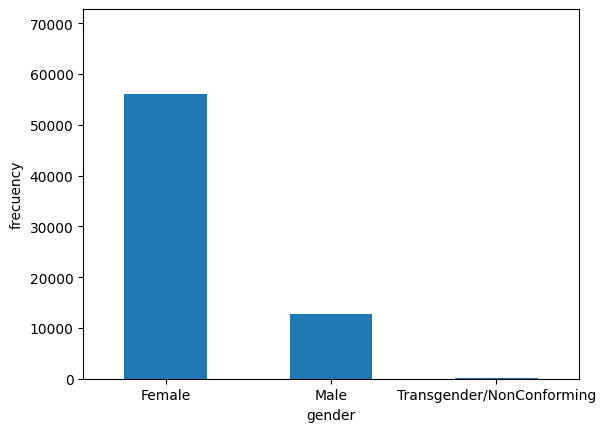

In [236]:
# Gender of the individuals
plot = new_data_set['gender'].value_counts().plot.bar(ylabel='frecuency', xlabel='gender')
labels = [label.set_rotation('horizontal') for label in plot.get_xticklabels()]
plot.margins(x=0, y=0.3)

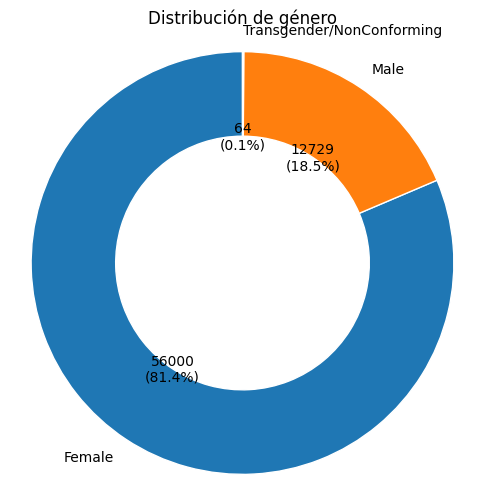

In [262]:
# Crear un gráfico donut para la columna 'gender'
gender_counts = new_data_set['gender'].value_counts()
fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(gender_counts, labels=gender_counts.index, autopct='', startangle=90, wedgeprops=dict(width=0.4, edgecolor='w'))

# Agregar un círculo en el centro para crear el agujero
center_circle = plt.Circle((0, 0), 0.3, color='white')
fig.gca().add_artist(center_circle)

# Obtener las cantidades numéricas
total = sum(gender_counts)
numeric_labels = [f'{count}\n({count/total*100:.1f}%)' for count in gender_counts]

# Agregar las cantidades numéricas como anotaciones
for i, autotext in enumerate(autotexts):
    autotext.set_text(numeric_labels[i])

# Título del gráfico
plt.title('Distribución de género')

# Mostrar el gráfico
plt.axis('equal')  # Esto asegura que el gráfico se vea como un círculo
plt.show()

In [266]:

# Agrupar los datos por género y rango de edades
grouped_data = new_data_set.groupby(['gender', 'ageBroad']).size().reset_index(name='count')

# Crear el gráfico de barras agrupado con valores numéricos
fig = px.bar(grouped_data, x='ageBroad', y='count', color='gender',
             title='Distribución de Género y Rango de Edades',
             text='count')  # Agregar los valores numéricos sobre las barras

fig.show()

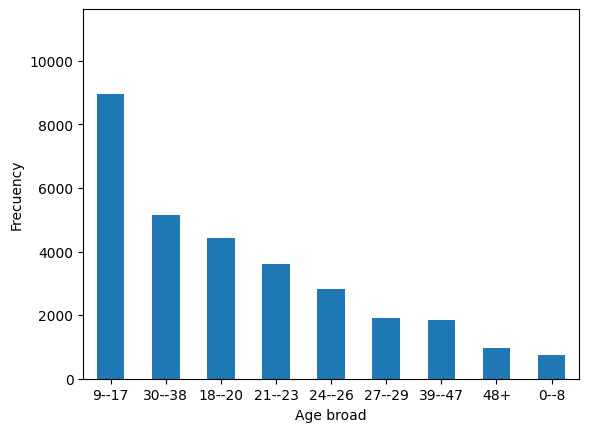

In [237]:
# Histogram of the age of the individual
age_count = new_data_set['ageBroad'].value_counts()
plot = new_data_set['ageBroad'].value_counts().plot.bar(xlabel="Age broad", ylabel="Frecuency")
labels = [label.set_rotation('horizontal') for label in plot.get_xticklabels()]
for bar, count in zip(plot.patches, age_count):
    plot.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 300,
        f"{count}",
        horizontalalignment='center', verticalalignment='bottom',
        fontsize=10, rotation=45, color='white')
plot.margins(x=0, y=0.3)

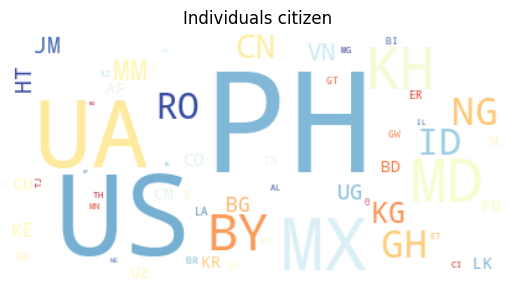

In [238]:
# Word cloud of the individual citizen
citizen = new_data_set['citizenship'].dropna().value_counts()

word_image = word_cloud.generate_from_frequencies(citizen)
plt.imshow(word_cloud, interpolation='bilinear',)
plt.title('Individuals citizen')
plt.axis('off')
plt.show()

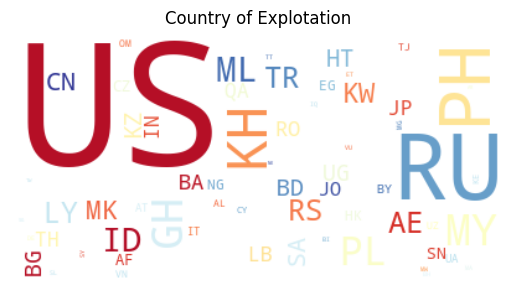

In [239]:
# Word cloud of the country where the individual were exploited
country_exploit = new_data_set['CountryOfExploitation'].dropna().value_counts()

word_image = word_cloud.generate_from_frequencies(country_exploit)
plt.imshow(word_cloud, interpolation='bilinear')
plt.title('Country of Explotation')
plt.axis('off')
plt.show()

In [240]:
count_totals = raw_data.filter(regex='(Concatenated|Relationship)$')
count_totals = count_totals.applymap(lambda x: len(x.split(';')), na_action='ignore').fillna(0).astype('int32')
count_totals.rename(columns=lambda x: re.sub(r'(Concatenated)?$', 'Count', x, count=1), inplace=True)

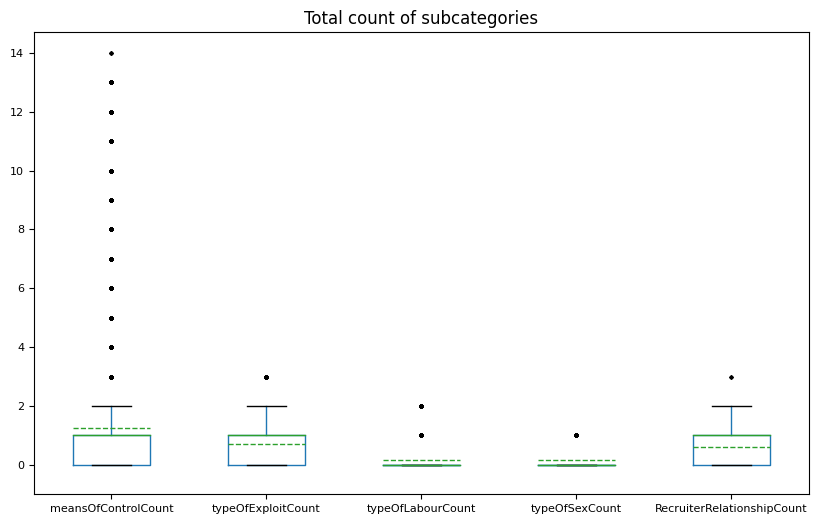

In [241]:
axis = count_totals.boxplot(
    fontsize=8,
    grid=False,
    figsize=(10, 6),
    showcaps=True,
    flierprops={'marker': '.', 'markersize': 3},
    showmeans=True,
    meanline=True,)
    # whis=(0, 98.54))
axis.set_ylim(-1)
title = axis.set_title('Total count of subcategories')

In [242]:
new_data_set.iloc[count_totals.index[count_totals["meansOfControlCount"] == 14]]

,yearOfRegistration,Datasource,gender,ageBroad,majorityStatus,majorityStatusAtExploit,majorityEntry,citizenship,isAbduction,RecruiterRelationship,...,typeOfLabourConcatenated_Not specified,typeOfLabourConcatenated_Other,typeOfLabourConcatenated_Peddling,typeOfLabourConcatenated_Transportation,typeOfSexConcatenated_Pornography,typeOfSexConcatenated_Private sexual services,typeOfSexConcatenated_Prostitution,typeOfSexConcatenated_Remote interactive services,country,alpha_3
17898,2015,Case Management,Female,18--20,Adult,NaN,NaN,MD,<NA>,NaN,...,0,0,0,0,0,0,1,0,"Moldova, Republic of",MDA
17922,2015,Case Management,Female,18--20,Adult,NaN,NaN,MD,<NA>,NaN,...,0,0,0,0,0,0,1,0,"Moldova, Republic of",MDA
17923,2015,Case Management,Female,18--20,Adult,NaN,NaN,MD,<NA>,NaN,...,0,0,0,0,0,0,1,0,"Moldova, Republic of",MDA
17926,2015,Case Management,Female,21--23,Adult,NaN,Adult,ID,<NA>,NaN,...,0,0,0,0,0,0,1,0,Indonesia,IDN
17928,2015,Case Management,Female,21--23,Adult,NaN,Adult,ID,<NA>,NaN,...,0,0,0,0,0,0,1,0,Indonesia,IDN
18758,2015,Case Management,Female,9--17,Minor,NaN,NaN,MD,<NA>,NaN,...,0,0,0,0,0,0,1,0,"Moldova, Republic of",MDA
18838,2015,Case Management,Male,0--8,Minor,NaN,NaN,MD,<NA>,NaN,...,0,0,0,0,0,0,1,0,"Moldova, Republic of",MDA
19814,2015,Case Management,Male,30--38,Adult,NaN,Adult,MM,<NA>,NaN,...,0,0,0,0,0,0,1,0,Myanmar,MMR
19875,2015,Case Management,Male,30--38,Adult,NaN,Adult,MM,<NA>,NaN,...,0,0,0,0,0,0,1,0,Myanmar,MMR
19880,2015,Case Management,Male,30--38,Adult,NaN,Adult,UA,0,Other,...,0,0,0,0,0,0,1,0,Ukraine,UKR


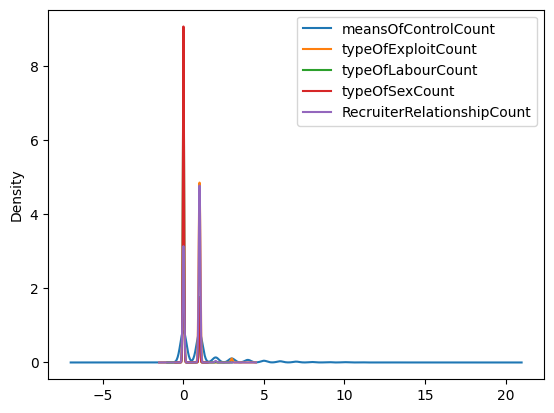

In [243]:
axis = count_totals.plot.kde()

C:\Users\Home\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



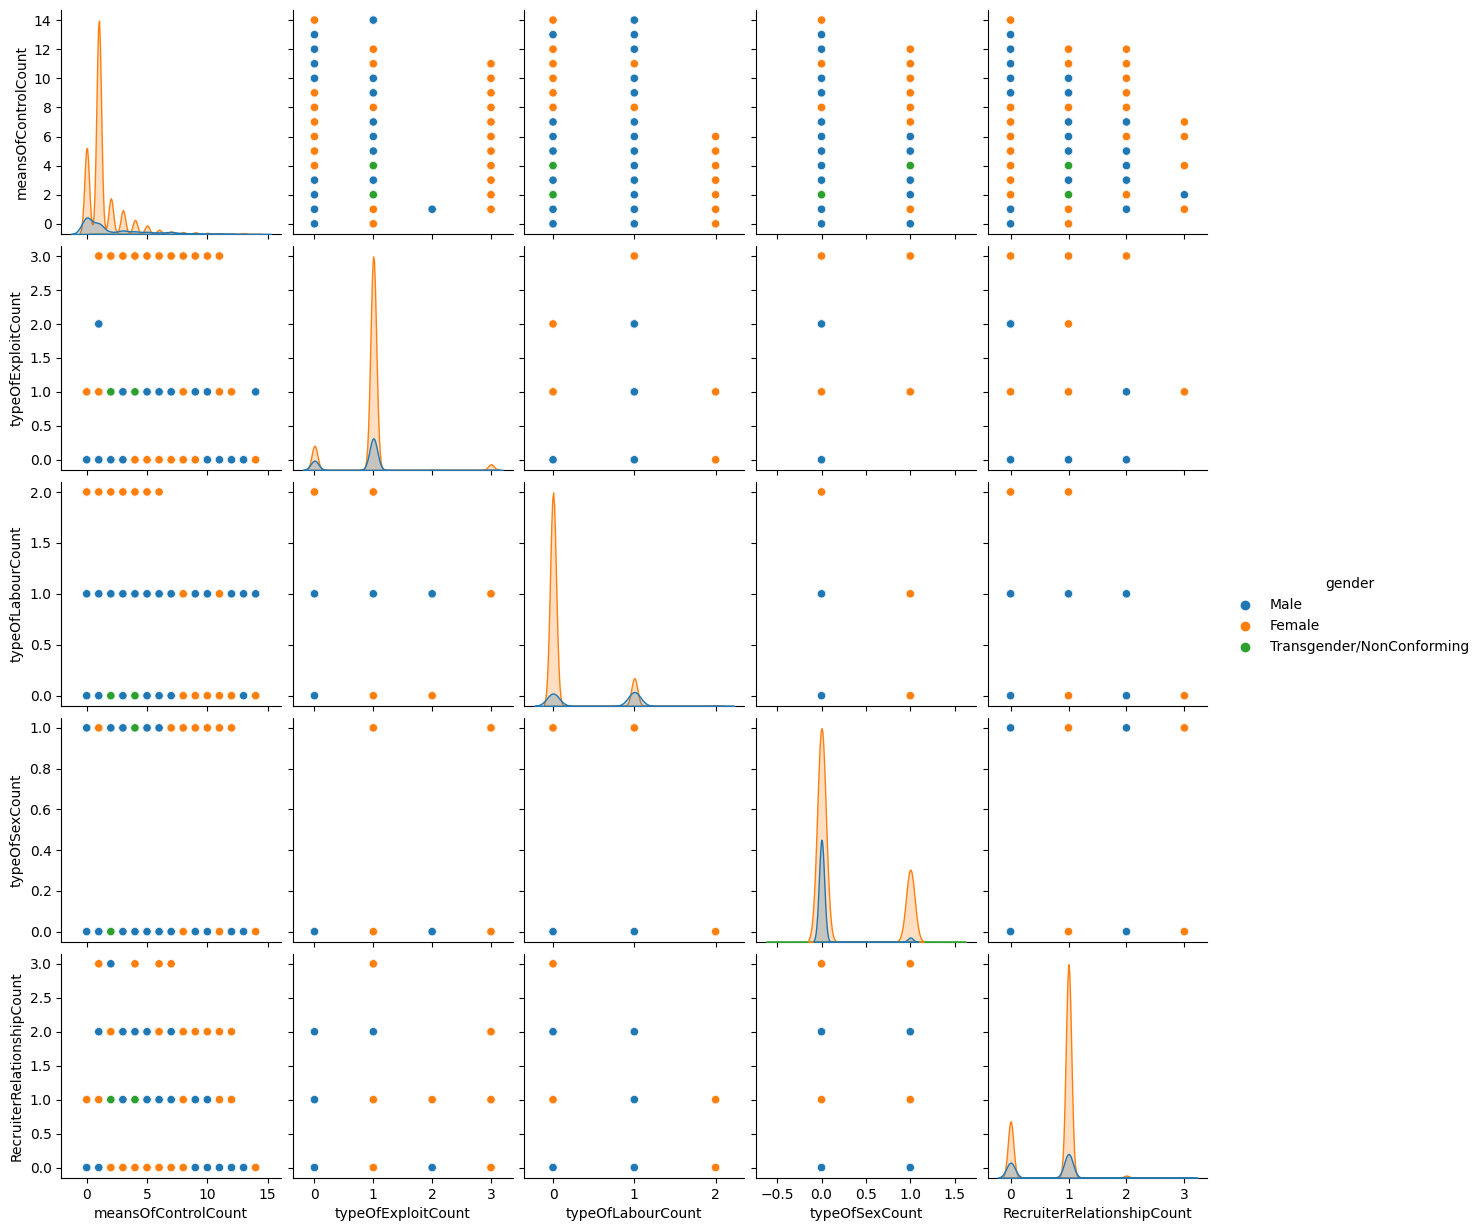

In [244]:

test = pd.concat([count_totals, new_data_set.select_dtypes('category')], axis=1)
test['gender']
g = sns.pairplot(test, hue='gender')

### Other thing

In [245]:
# Change categorical data type from string to encoder number
new_data_set['citizenship'].map(country_code).head()
new_data_set['CountryOfExploitation'].map(country_code)

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
97730    434
97731    434
97732    434
97746    434
97748    434
Name: CountryOfExploitation, Length: 75672, dtype: category
Categories (77, object): ['784', '004', '008', '032', ..., '860', '704', '548', '710']